# Decision Trees on Amazon Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using three techniques: **<br>
**1. Average W2V.**<br>
**2. Average TFIDF-W2V.**<br>
**3. GLoVe(Pre-trained).**<br>

**Then perform following tasks under each technique:**<br>
**Task 1. Split train and test data in a ratio of 80:20.** <br>
**Task 2. Perform GridSearch Cross Validation to find optimal depth of decision tree.**<br>
**Task 3. Apply DecisionTreeClassifier and report accuracy. Also check for train error.**<br>
**Task 4. Plot decision tree using graphviz.**<br>

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import gensim
import csv
import re
import graphviz 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

In [3]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [4]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [5]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [6]:
data.shape

(364171, 12)

In [7]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [8]:
def changingScores(score):
    if score == "Positive":
        return 1
    else:
        return 0

In [9]:
# changing score
# Positive = 1
# Negative = 0
actualScore = list(data["Score"])                                                                                         
positiveNegative = list(map(changingScores, actualScore)) #map(function, list of numbers)
data['Score'] = positiveNegative

In [10]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [11]:
allPositiveReviews = data[(data["Score"] == 1)]

In [12]:
allPositiveReviews.shape

(307061, 12)

In [13]:
positiveReviews_5000 = allPositiveReviews[:5000]

In [14]:
positiveReviews_5000.shape

(5000, 12)

In [15]:
positiveReviews_5000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...
5,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...


In [16]:
allNegativeReviews = data[(data["Score"] == 0)]

In [17]:
allNegativeReviews.shape

(57110, 12)

In [18]:
negativeReviews_5000 = allNegativeReviews[:5000]

In [19]:
negativeReviews_5000.shape

(5000, 12)

In [20]:
negativeReviews_5000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
11,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,cat have been happili eat felida platinum for ...
15,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,0,1348099200,poor taste,I love eating them and they are good for watch...,love eat them and they are good for watch and ...
25,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",the candi just red flavor just plan and chewi ...
45,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,0,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",this oatmeal not good it mushi soft dont like ...


In [21]:
frames_10000 = [positiveReviews_5000, negativeReviews_5000]

In [22]:
FinalPositiveNegative = pd.concat(frames_10000)

In [23]:
FinalPositiveNegative.shape

(10000, 12)

In [24]:
#Sorting FinalDataframe by "Time"
FinalSortedPositiveNegative_10000 = FinalPositiveNegative.sort_values('Time', axis=0, ascending=True, inplace=False)

In [25]:
FinalSortedPositiveNegativeScore_10000 = FinalSortedPositiveNegative_10000["Score"]

In [26]:
FinalSortedPositiveNegative_10000.shape

(10000, 12)

In [27]:
FinalSortedPositiveNegativeScore_10000.shape

(10000,)

In [28]:
Data = FinalSortedPositiveNegative_10000

In [29]:
Data_Labels = FinalSortedPositiveNegativeScore_10000

In [30]:
print(Data.shape)
print(Data_Labels.shape)

(10000, 12)
(10000,)


In [31]:
Data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
772,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,this was realli good idea and the final produc...
771,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,just receiv shipment and could hard wait tri t...
5822,7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,1,1075420800,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,the winter when fresh blueberri exceed our foo...
2418,3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,1,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...
5206,6790,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,1,1083456000,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...,love the snack want buy bunch ship amazon more...


## 1. Avg W2V

In [32]:
i = 0
listOfSentences = []
for sentence in Data["ProcessedText"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [33]:
print(Data['ProcessedText'].values[0])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

this was realli good idea and the final product outstand use the decal car window and everybodi ask where bought the decal made two thumb


[['this', 'was', 'realli', 'good', 'idea', 'and', 'the', 'final', 'product', 'outstand', 'use', 'the', 'decal', 'car', 'window', 'and', 'everybodi', 'ask', 'where', 'bought', 'the', 'decal', 'made', 'two', 'thumb'], ['just', 'receiv', 'shipment', 'and', 'could', 'hard', 'wait', 'tri', 'this', 'product', 'love', 'which', 'what', 'call', 'them', 'instead', 'sticker', 'becaus', 'they', 'can', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'revers', 'use', 'her', 'car', 'window', 'they', 'print', 'beauti', 'have', 'the', 'print', 'shop', 'program', 'go', 'have', 'lot', 'fun', 'with', 'this', 'product', 'becaus', 'there', 'are', 'window', 'everywher', 'and', 'other', 'surfac', 'like', 'screen', 'and', 'comput', 'monitor']]


<class 'list'>


In [34]:
w2vModel = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)

In [35]:
# compute average word2vec for each review.
sentenceAsW2V = []
for sentence in listOfSentences:
    sentenceVector = np.zeros(300)
    TotalWordsPerSentence = 0
    for word in sentence:
        try:
            vect = w2vModel.wv[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
        except:
            pass
    sentenceVector /= TotalWordsPerSentence
    sentenceAsW2V.append(sentenceVector)

print(type(sentenceAsW2V))
print(len(sentenceAsW2V))
print(len(sentenceAsW2V[0]))

<class 'list'>
10000
300


### Task 1. Split train and test data in a ratio of 80:20. 

In [36]:
train_AvgW2V, test_AvgW2V, train_labels_AvgW2V, test_labels_AvgW2V = train_test_split(sentenceAsW2V, Data_Labels, test_size = 0.2)

In [37]:
len(train_AvgW2V), len(test_AvgW2V), len(train_labels_AvgW2V), len(test_labels_AvgW2V)

(8000, 2000, 8000, 2000)

### Task 2. Perform GridSearch Cross Validation to find optimal depth of decision tree.

In [38]:
clf = DecisionTreeClassifier(min_samples_split = 4, min_samples_leaf = 4)
    
hyper_parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 17]}
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestCV.fit(train_AvgW2V, train_labels_AvgW2V)
    
print(bestCV.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [39]:
best_parameter = bestCV.best_params_ 
best_parameter["max_depth"]

5

In [40]:
scoreData = bestCV.grid_scores_
scoreData

[mean: 0.70037, std: 0.01147, params: {'max_depth': 1},
 mean: 0.70950, std: 0.00853, params: {'max_depth': 2},
 mean: 0.72288, std: 0.01223, params: {'max_depth': 3},
 mean: 0.73275, std: 0.00629, params: {'max_depth': 4},
 mean: 0.73550, std: 0.00935, params: {'max_depth': 5},
 mean: 0.73088, std: 0.00579, params: {'max_depth': 6},
 mean: 0.71837, std: 0.00401, params: {'max_depth': 7},
 mean: 0.70862, std: 0.00808, params: {'max_depth': 8},
 mean: 0.70937, std: 0.00697, params: {'max_depth': 9},
 mean: 0.69737, std: 0.00369, params: {'max_depth': 11},
 mean: 0.68937, std: 0.00570, params: {'max_depth': 13},
 mean: 0.69475, std: 0.00222, params: {'max_depth': 15},
 mean: 0.69025, std: 0.00659, params: {'max_depth': 17}]

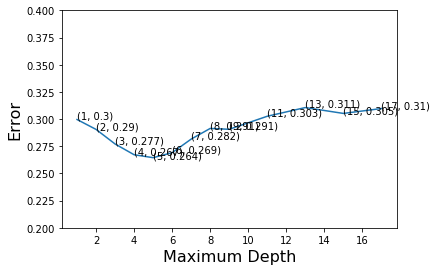

In [41]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["max_depth"])
    
plt.plot(parameter, np.round(error, 4))
plt.ylim(ymin=0.2) 
plt.ylim(ymax=0.4)
plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("Error", fontsize=16)

error1 = []
for e in error:
    error1.append(np.round(e,3))
    
parameter1 = []
for p in parameter:
    parameter1.append(np.round(p,3))

for xy in zip(parameter1, error1):
    plt.annotate(xy,xy)

plt.show()

### Task 3. Apply DecisionTreeClassifier and report accuracy. Also check for train error.

In [42]:
clf_AvgW2V = DecisionTreeClassifier(max_depth = best_parameter["max_depth"], min_samples_split = 4, min_samples_leaf = 4)

clf_AvgW2V = clf_AvgW2V.fit(train_AvgW2V, train_labels_AvgW2V)

prediction_AvgW2V = clf_AvgW2V.predict(test_AvgW2V)

AccuracyScore_AvgW2V = accuracy_score(test_labels_AvgW2V, prediction_AvgW2V) * 100

print("Accuracy score of decision tree = "+str(AccuracyScore_AvgW2V)+"%")

Accuracy score of decision tree = 73.2%


In [43]:
model_AvgW2V_tr = DecisionTreeClassifier(max_depth = best_parameter["max_depth"], min_samples_split = 4, min_samples_leaf = 4)

model_AvgW2V_tr.fit(train_AvgW2V, train_labels_AvgW2V)

prediction_AvgW2V_tr = model_AvgW2V_tr.predict(train_AvgW2V)

AccuracyScore_AvgW2V_tr = accuracy_score(train_labels_AvgW2V, prediction_AvgW2V_tr)

print("Train error of decision tree = "+str(1- AccuracyScore_AvgW2V_tr))

Train error of decision tree = 0.21987500000000004


In [44]:
Confusion_Matrix = confusion_matrix(test_labels_AvgW2V, prediction_AvgW2V)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[727 250]
 [286 737]]


In [45]:
tn, fp, fn, tp = confusion_matrix(test_labels_AvgW2V, prediction_AvgW2V).ravel()
tn, fp, fn, tp

(727, 250, 286, 737)

### Task 4. Plot decision tree using graphviz.

In [65]:
dot_data = tree.export_graphviz(clf_AvgW2V, out_file=None, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("AvgW2V_DecisionTree_Graph") 

'AvgW2V_DecisionTree_Graph.pdf'

## 2. Average TFIDF-W2V.

In [49]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
tfidf = tfidf_vect.fit_transform(Data["ProcessedText"].values)

In [50]:
w2v_Model = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)

In [51]:
print(tfidf.shape)
print(type(tfidf))

(10000, 237703)
<class 'scipy.sparse.csr.csr_matrix'>


In [52]:
# TF-IDF weighted Word2Vec
tfidf_features = tfidf_vect.get_feature_names()

tfidf_w2v = []
reviews = 0

for sentence in listOfSentences:
    sentenceVector = np.zeros(300)
    weightTfidfSum = 0
    for word in sentence:
        try:
            W2V_Vector = w2v_Model.wv[word]
            tfidfVector = tfidf[reviews, tfidf_features.index(word)]
            sentenceVector += (W2V_Vector * tfidfVector)
            weightTfidfSum += tfidfVector
        except:
            pass
    sentenceVector /= weightTfidfSum
    tfidf_w2v.append(sentenceVector)
    reviews += 1

### Task 1. Split train and test data in a ratio of 80:20

In [53]:
train_tfidf_w2v, test_tfidf_w2v, train_labels_tfidf_w2v, test_labels_tfidf_w2v = train_test_split(tfidf_w2v, Data_Labels, test_size = 0.2)

In [54]:
len(train_tfidf_w2v), len(test_tfidf_w2v), len(train_labels_tfidf_w2v), len(test_labels_tfidf_w2v)

(8000, 2000, 8000, 2000)

### Task 2. Perform GridSearch Cross Validation to find optimal depth of decision tree.

In [56]:
clf = DecisionTreeClassifier(min_samples_split = 4, min_samples_leaf = 4)
    
hyper_parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 17]}
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestCV.fit(train_tfidf_w2v, train_labels_tfidf_w2v)
    
print(bestCV.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [57]:
best_parameter = bestCV.best_params_ 
best_parameter["max_depth"]

5

In [58]:
scoreData = bestCV.grid_scores_
scoreData

[mean: 0.67325, std: 0.00715, params: {'max_depth': 1},
 mean: 0.67550, std: 0.00439, params: {'max_depth': 2},
 mean: 0.68537, std: 0.00670, params: {'max_depth': 3},
 mean: 0.69650, std: 0.00656, params: {'max_depth': 4},
 mean: 0.70037, std: 0.00464, params: {'max_depth': 5},
 mean: 0.69763, std: 0.00508, params: {'max_depth': 6},
 mean: 0.69675, std: 0.00997, params: {'max_depth': 7},
 mean: 0.68137, std: 0.00942, params: {'max_depth': 8},
 mean: 0.67312, std: 0.01638, params: {'max_depth': 9},
 mean: 0.67050, std: 0.01209, params: {'max_depth': 11},
 mean: 0.66825, std: 0.01034, params: {'max_depth': 13},
 mean: 0.66212, std: 0.01194, params: {'max_depth': 15},
 mean: 0.66325, std: 0.00999, params: {'max_depth': 17}]

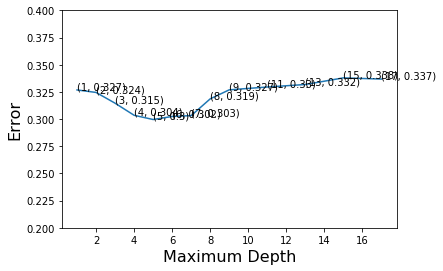

In [59]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["max_depth"])
    
plt.plot(parameter, np.round(error, 4))
plt.ylim(ymin=0.2) 
plt.ylim(ymax=0.4)
plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("Error", fontsize=16)

error1 = []
for e in error:
    error1.append(np.round(e,3))
    
parameter1 = []
for p in parameter:
    parameter1.append(np.round(p,3))

for xy in zip(parameter1, error1):
    plt.annotate(xy,xy)

plt.show()

### Task 3. Apply DecisionTreeClassifier and report accuracy. Also check for train error

In [60]:
clf_TFIDF_W2V = DecisionTreeClassifier(max_depth = best_parameter["max_depth"], min_samples_split = 4, min_samples_leaf = 4)

clf_TFIDF_W2V = clf_TFIDF_W2V.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

prediction_TFIDF_W2V = clf_TFIDF_W2V.predict(test_tfidf_w2v)

AccuracyScore_TFIDF_W2V = accuracy_score(test_labels_tfidf_w2v, prediction_TFIDF_W2V) * 100

print("Accuracy score of decision tree = "+str(AccuracyScore_TFIDF_W2V)+"%")

Accuracy score of decision tree = 70.85000000000001%


In [96]:
clf_TFIDF_W2V_tr = DecisionTreeClassifier(max_depth = best_parameter["max_depth"], min_samples_split = 4, min_samples_leaf = 4)

clf_TFIDF_W2V_tr = clf_TFIDF_W2V_tr.fit(train_tfidf_w2v, train_labels_tfidf_w2v)

prediction_TFIDF_W2V_tr = clf_TFIDF_W2V_tr.predict(train_tfidf_w2v)

AccuracyScore_TFIDF_W2V_tr = accuracy_score(train_labels_tfidf_w2v, prediction_TFIDF_W2V_tr)

print("Train error of decision tree = "+str(1- AccuracyScore_TFIDF_W2V_tr))

Train error of decision tree = 0.25712500000000005


In [62]:
Confusion_Matrix = confusion_matrix(test_labels_tfidf_w2v, prediction_TFIDF_W2V)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[717 300]
 [283 700]]


In [63]:
tn, fp, fn, tp = confusion_matrix(test_labels_AvgW2V, prediction_AvgW2V).ravel()
tn, fp, fn, tp

(727, 250, 286, 737)

### Task 4. Plot decision tree using graphviz.

In [64]:
dot_data = tree.export_graphviz(clf_TFIDF_W2V, out_file=None, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("TFIDF_W2V_DecisionTree_Graph") 

'TFIDF_W2V_DecisionTree_Graph.pdf'

## 3. GLoVe

In [32]:
def cleanhtml(sentence): #function to clean htmltags
    cleanr = re.compile("<.*?>")
    cleantext = re.sub(cleanr, " ", sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [33]:
#removing HTML tags and punctuation from our text

i = 0
final_string = []
s = ""
for sentence in data["Text"].values:
    filteredSentence = []
    EachReviewText = ""
    sentenceHTMLCleaned = cleanhtml(sentence)
    for eachWord in sentenceHTMLCleaned.split():
        for sentencePunctCleaned in cleanpunc(eachWord).split():
            if((sentencePunctCleaned.isalpha()) & (len(sentencePunctCleaned)>2)):
                sentenceLower = sentencePunctCleaned.lower()
                filteredSentence.append(sentenceLower)
                     
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [34]:
data["ProcessedText2"] = final_string

In [35]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,ProcessedText2
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...,have bought several the vitality canned dog fo...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...,product arrived labeled jumbo salted peanuts t...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...,this confection that has been around few centu...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...,great taffy great price there was wide assortm...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...,got wild hair for taffy and ordered this five ...


In [36]:
allPositiveReviews2 = data[(data["Score"] == 1)]

In [37]:
allPositiveReviews2.shape

(307061, 13)

In [38]:
positiveReviews2_500 = allPositiveReviews2[:500]

In [39]:
positiveReviews2_500.shape

(500, 13)

In [40]:
positiveReviews2_500.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,ProcessedText2
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...,have bought several the vitality canned dog fo...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...,this confection that has been around few centu...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...,great taffy great price there was wide assortm...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...,got wild hair for taffy and ordered this five ...
5,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...,this saltwater taffy had great flavors and was...


In [41]:
allNegativeReviews2 = data[(data["Score"] == 0)]

In [42]:
allNegativeReviews2.shape

(57110, 13)

In [43]:
negativeReviews2_500 = allNegativeReviews2[:500]

In [44]:
negativeReviews2_500.shape

(500, 13)

In [45]:
negativeReviews2_500.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,ProcessedText2
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...,product arrived labeled jumbo salted peanuts t...
11,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,cat have been happili eat felida platinum for ...,cats have been happily eating felidae platinum...
15,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,0,1348099200,poor taste,I love eating them and they are good for watch...,love eat them and they are good for watch and ...,love eating them and they are good for watchin...
25,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",the candi just red flavor just plan and chewi ...,the candy just red flavor just plan and chewy ...
45,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,0,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",this oatmeal not good it mushi soft dont like ...,this oatmeal not good its mushy soft dont like...


In [46]:
frames2_1000 = [positiveReviews2_500, negativeReviews2_500]

In [47]:
FinalPositiveNegative2 = pd.concat(frames2_1000)

In [48]:
FinalPositiveNegative2.shape

(1000, 13)

In [49]:
#Sorting FinalDataframe by "Time"
FinalSortedPositiveNegative2_1000 = FinalPositiveNegative2.sort_values('Time', axis=0, ascending=True, inplace=False)

In [50]:
FinalSortedPositiveNegativeScore2_1000 = FinalSortedPositiveNegative2_1000["Score"]

In [51]:
FinalSortedPositiveNegative2_1000.shape

(1000, 13)

In [52]:
FinalSortedPositiveNegativeScore2_1000.shape

(1000,)

In [53]:
Data2 = FinalSortedPositiveNegative2_1000

In [54]:
Data2_Labels = FinalSortedPositiveNegativeScore2_1000

In [55]:
print(Data2.shape)
print(Data2_Labels.shape)

(1000, 13)
(1000,)


In [56]:
Data2.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,ProcessedText2
9,10,11,B0001PB9FE,A3HDKO7OW0QNK4,Canadian Fan,1,1,1,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,dont know it the cactus the tequila just the u...,dont know its the cactus the tequila just the ...
1653,2106,2296,B0001VWE02,AQM74O8Z4FMS0,Sunshine,0,0,0,1127606400,Below standard,Too much of the white pith on this orange peel...,too much the white pith this orang peel make t...,too much the white pith this orange peel makin...
2558,3667,3984,B0005ZHWXI,A26HFSVLAGULIM,"Heather L. Parisi ""Robert and Heather Parisi""",0,1,0,1131235200,ADD SKIM MILK - BANANA - BLUEBERRIES - WHEAT...,SOMETHING TO EAT IF YOU'RE STARVING - BUT PLEA...,someth eat your starv but pleas give real food...,something eat youre starving but please give r...
1341,1779,1935,B000F4EU52,A2PNOU7NXB1JE4,"Peggy ""pab920""",14,17,0,1153008000,Inside of can corroded,"After I enptied the can, I noticed it was blac...",after enpti the can notic was black area the t...,after enptied the can noticed was black area t...
2307,3362,3661,B000FDKQC4,A1PNP10DP0M7V1,"D. Chamberlain ""dchamberlain072002""",7,8,0,1156377600,A Bitter Pill,I have to say that I really wanted to like the...,have say that realli want like these muffin bu...,have say that really wanted like these muffins...


In [57]:
i = 0
listOfSentences2 = []
for sentence in Data2["ProcessedText2"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences2.append(subSentence)

In [58]:
print(Data2['ProcessedText2'].values[0])
print("\n")
print(listOfSentences2[0:2])
print("\n")
print(type(listOfSentences2))
print("\n")
print(len(listOfSentences2))

dont know its the cactus the tequila just the unique combination ingredients but the flavour this hot sauce makes one kind picked bottle once trip were and brought back home with and were totally blown away when realized that simply couldnt find anywhere our city were bummed now because the magic the internet have case the sauce and are ecstatic because you love hot sauce mean really love hot sauce but dont want sauce that tastelessly burns your throat grab bottle tequila picante gourmet inclan just realize that once you taste you will never want use any other sauce thank you for the personal incredible service


[['dont', 'know', 'its', 'the', 'cactus', 'the', 'tequila', 'just', 'the', 'unique', 'combination', 'ingredients', 'but', 'the', 'flavour', 'this', 'hot', 'sauce', 'makes', 'one', 'kind', 'picked', 'bottle', 'once', 'trip', 'were', 'and', 'brought', 'back', 'home', 'with', 'and', 'were', 'totally', 'blown', 'away', 'when', 'realized', 'that', 'simply', 'couldnt', 'find', 'anyw

In [59]:
#loading pre-trained GloVe vectors
words = pd.read_table("glove.6B.100d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE) 

# Here, We have downloaded pre-trained Glove vectors. You just have to type "Glove word vectors" on google then click on 
# "https://nlp.stanford.edu/projects/glove/" link. Then you can download pre-trained word-vectors. Zip file will be 
# downloaded, you just have to extract it then load the txt file from extracted folder into ipython notebook using pandas,
# just like we have done above.

In [60]:
def check(word):
    if (words.index == word).any():
        return 1
    else:
        return 0

In [61]:
# compute average GloVe for each review.
sentenceAsGlove = []
for sentence in listOfSentences2:
    sentenceVector = np.zeros(100)
    TotalWordsPerSentence = 0
    for word in sentence:
        if check(word) == 1:
            vect = words.loc[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
            
    sentenceVector /= TotalWordsPerSentence
    sentenceAsGlove.append(sentenceVector)

print(type(sentenceAsGlove))
print(len(sentenceAsGlove))
print(len(sentenceAsGlove[0]))

<class 'list'>
1000
100


### Task 1. Split train and test data in a ratio of 80:20

In [62]:
train_GLoVe, test_GLoVe, train_labels_GLoVe, test_labels_GLoVe = train_test_split(sentenceAsGlove, Data2_Labels, test_size = 0.2)

In [63]:
len(train_GLoVe), len(test_GLoVe), len(train_labels_GLoVe), len(test_labels_GLoVe)

(800, 200, 800, 200)

### Task 2. Perform GridSearch Cross Validation to find optimal depth of decision tree.

In [83]:
clf = DecisionTreeClassifier(min_samples_split = 4, min_samples_leaf = 4)
    
hyper_parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 17]}
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestCV.fit(train_GLoVe, train_labels_GLoVe)
    
print(bestCV.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [84]:
best_parameter = bestCV.best_params_ 
best_parameter["max_depth"]

1

In [85]:
scoreData = bestCV.grid_scores_
scoreData

[mean: 0.65625, std: 0.00854, params: {'max_depth': 1},
 mean: 0.63125, std: 0.01595, params: {'max_depth': 2},
 mean: 0.65250, std: 0.03836, params: {'max_depth': 3},
 mean: 0.63125, std: 0.02002, params: {'max_depth': 4},
 mean: 0.62250, std: 0.01838, params: {'max_depth': 5},
 mean: 0.62875, std: 0.03259, params: {'max_depth': 6},
 mean: 0.62875, std: 0.02142, params: {'max_depth': 7},
 mean: 0.63125, std: 0.03681, params: {'max_depth': 8},
 mean: 0.63750, std: 0.01427, params: {'max_depth': 9},
 mean: 0.62875, std: 0.01893, params: {'max_depth': 11},
 mean: 0.62625, std: 0.01323, params: {'max_depth': 13},
 mean: 0.63000, std: 0.02929, params: {'max_depth': 15},
 mean: 0.62875, std: 0.02118, params: {'max_depth': 17}]

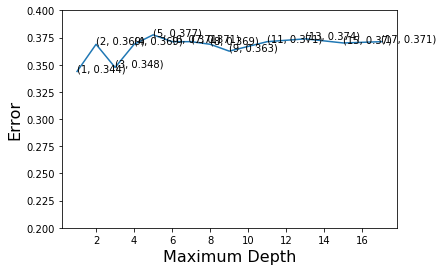

In [86]:
error = []
parameter = []
for i in range(len(scoreData)):
    error.append(1 - scoreData[i][1])
    parameter.append(scoreData[i][0]["max_depth"])
    
plt.plot(parameter, np.round(error, 4))
plt.ylim(ymin=0.2) 
plt.ylim(ymax=0.4)
plt.xlabel("Maximum Depth", fontsize=16)
plt.ylabel("Error", fontsize=16)

error1 = []
for e in error:
    error1.append(np.round(e,3))
    
parameter1 = []
for p in parameter:
    parameter1.append(np.round(p,3))

for xy in zip(parameter1, error1):
    plt.annotate(xy,xy)

plt.show()

### Task 3. Apply DecisionTreeClassifier and report accuracy. Also check for train error

In [92]:
clf_GLoVe = DecisionTreeClassifier(max_depth = 5, min_samples_split = 4, min_samples_leaf = 4)

clf_GLoVe = clf_GLoVe.fit(train_GLoVe, train_labels_GLoVe)

prediction_GLoVe = clf_GLoVe.predict(test_GLoVe)

AccuracyScore_GLoVe = accuracy_score(test_labels_GLoVe, prediction_GLoVe) * 100

print("Accuracy score of decision tree = "+str(AccuracyScore_GLoVe)+"%")

Accuracy score of decision tree = 64.0%


In [93]:
clf_GLoVe_tr = DecisionTreeClassifier(max_depth = 5, min_samples_split = 4, min_samples_leaf = 4)

clf_GLoVe_tr = clf_GLoVe_tr.fit(train_GLoVe, train_labels_GLoVe)

prediction_GLoVe_tr = clf_GLoVe_tr.predict(train_GLoVe)

AccuracyScore_GLoVe_tr = accuracy_score(train_labels_GLoVe, prediction_GLoVe_tr)

print("Train error of decision tree = "+str(1 - AccuracyScore_GLoVe_tr))

Train error of decision tree = 0.17000000000000004


In [94]:
Confusion_Matrix = confusion_matrix(test_labels_GLoVe, prediction_GLoVe)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[56 33]
 [39 72]]


In [95]:
tn, fp, fn, tp = confusion_matrix(test_labels_GLoVe, prediction_GLoVe).ravel()
tn, fp, fn, tp

(56, 33, 39, 72)

### Task 4. Plot decision tree using graphviz.

In [96]:
dot_data = tree.export_graphviz(clf_GLoVe, out_file=None, filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("GLoVe_DecisionTree_Graph") 

'GLoVe_DecisionTree_Graph.pdf'

# Summary

## Avg W2V
**1. Optimal Value of depth from Grid Search = 5**<br>
**2. Accuracy = 73.2%**<br>
**3. Train Error = 0.2198**<br>
## TFIDF-W2V
**1. Optimal Value of depth from Grid Search = 5**<br>
**2. Accuracy = 70.85%**<br>
**3. Train Error = 0.2571**<br>
## GLoVe
**1. Optimal Value of depth from Grid Search = 1**<br>
**2. Final considered value of depth = 5**<br> 
**3. Accuracy = 64%**<br>
**4. Train Error = 0.170**<br>